In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from linearmodels import PanelOLS
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
suicide = pd.read_csv('who_suicide_statistics.csv')
suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


In [3]:
classification = pd.read_excel('CLASS.xls')
classification = classification.drop(0)
classification.columns = ['Economy', 'income_group']
classification.head()

,Economy,income_group
1,Afghanistan,Low income
2,Albania,Upper middle income
3,Algeria,Upper middle income
4,American Samoa,Upper middle income
5,Andorra,High income


In [4]:
suicide = suicide.merge(classification, left_on='country', right_on='Economy').drop(['Economy'], axis=1)
suicide.head(10)

,country,year,sex,age,suicides_no,population,income_group
0,Albania,1985,female,15-24 years,NaN,277900.0,Upper middle income
1,Albania,1985,female,25-34 years,NaN,246800.0,Upper middle income
2,Albania,1985,female,35-54 years,NaN,267500.0,Upper middle income
3,Albania,1985,female,5-14 years,NaN,298300.0,Upper middle income
4,Albania,1985,female,55-74 years,NaN,138700.0,Upper middle income
5,Albania,1985,female,75+ years,NaN,34200.0,Upper middle income
6,Albania,1985,male,15-24 years,NaN,301400.0,Upper middle income
7,Albania,1985,male,25-34 years,NaN,264200.0,Upper middle income
8,Albania,1985,male,35-54 years,NaN,296700.0,Upper middle income
9,Albania,1985,male,5-14 years,NaN,325800.0,Upper middle income


In [5]:
unemployment = pd.read_csv('Unemployment.csv')
unemployment = pd.melt(unemployment, id_vars=['Country Name', 'Series Name'])

unemployment['sex'] = np.where(unemployment['Series Name'] == 
                               'Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)', 
                               'male', 
                          np.where(unemployment['Series Name'] == 
                                   'Unemployment, female (% of female labor force) (modeled ILO estimate)', 'female', 
                                   np.where(unemployment['Series Name'] == 
                                            'Unemployment, male (% of male labor force) (modeled ILO estimate)', 
                                            'male','female')))

unemployment = unemployment.replace(['Unemployment, female (% of female labor force) (modeled ILO estimate)', 
                      'Unemployment, male (% of male labor force) (modeled ILO estimate)',
                      'Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)',
                      'Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)'],
                      ['Adult', 'Adult', 'Youth', 'Youth'])

unemployment['variable'] = unemployment['variable'].str.slice(0, 4)

unemployment.columns = ['country', 'Age', 'year', 'unemployment', 'sex']

unemployment['year'] = unemployment['year'].astype(str).astype(int)
unemployment.head()

,country,Age,year,unemployment,sex
0,Afghanistan,Youth,1991,25.31500053,male
1,Afghanistan,Youth,1991,26.88800049,female
2,Afghanistan,Adult,1991,11.61600018,male
3,Afghanistan,Adult,1991,14.56099987,female
4,Albania,Youth,1991,37.2859993,male


In [6]:
suicide['Age'] = np.where(suicide['age'] == '5-14 years', 'Youth', 
                          np.where(suicide['age'] == '15-24 years', 'Youth', 'Adult'))
suicide.head(10)

,country,year,sex,age,suicides_no,population,income_group,Age
0,Albania,1985,female,15-24 years,NaN,277900.0,Upper middle income,Youth
1,Albania,1985,female,25-34 years,NaN,246800.0,Upper middle income,Adult
2,Albania,1985,female,35-54 years,NaN,267500.0,Upper middle income,Adult
3,Albania,1985,female,5-14 years,NaN,298300.0,Upper middle income,Youth
4,Albania,1985,female,55-74 years,NaN,138700.0,Upper middle income,Adult
5,Albania,1985,female,75+ years,NaN,34200.0,Upper middle income,Adult
6,Albania,1985,male,15-24 years,NaN,301400.0,Upper middle income,Youth
7,Albania,1985,male,25-34 years,NaN,264200.0,Upper middle income,Adult
8,Albania,1985,male,35-54 years,NaN,296700.0,Upper middle income,Adult
9,Albania,1985,male,5-14 years,NaN,325800.0,Upper middle income,Youth


In [7]:
suicide = suicide.merge(unemployment, on=['country', 'Age', 'year', 'sex']).drop(['Age'], axis=1)
suicide = suicide[['country', 'income_group', 'year', 'sex', 'age', 'suicides_no', 'population', 'unemployment']]
suicide['unemployment'] = suicide['unemployment'].replace('..', np.nan)
suicide['unemployment'] = suicide['unemployment'].astype(str).astype(float)
suicide.head()

,country,income_group,year,sex,age,suicides_no,population,unemployment
0,Albania,Upper middle income,1991,female,15-24 years,NaN,301100.0,24.313
1,Albania,Upper middle income,1991,female,5-14 years,NaN,333300.0,24.313
2,Albania,Upper middle income,1991,female,25-34 years,NaN,274700.0,27.680
3,Albania,Upper middle income,1991,female,35-54 years,NaN,316500.0,27.680
4,Albania,Upper middle income,1991,female,55-74 years,NaN,160800.0,27.680


IDEA: create a linear model to predict population using each variable (except suicides_no). Use the valid entries as training data and then fill in the missing entries using the model. Then do the same thing regressing all of the variables on suicides_no to fill in the missing entries. Then conduct the overall analysis and get rid of country to avoid collinearity. Talk to Jen about panel vs cross sectional vs time series vs straight up regression. Also should I predict suicides_no with population as a feature or suicide rate, dividing suicides by population.

In [8]:
pois_pop = smf.glm('population~country+income_group+year+sex+age', data=suicide, missing='drop',
                   family=sm.families.Poisson()).fit()
pois_pop.summary()
na_pop = suicide[suicide['population'].isnull()==True]
preds = pois_pop.predict(na_pop)
na_pop['population'] = preds
suicide.update(na_pop)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [9]:
lm_unemployment = smf.ols('unemployment~country+income_group+year+sex+age+population', data=suicide, 
                          missing='drop').fit()
lm_unemployment.summary()
#Note the R-squared for the imputation model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           unemployment   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     505.1
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:45:04   Log-Likelihood:                -73060.
No. Observations:               23868   AIC:                         1.463e+05
Df Residuals:                   23761   BIC:                         1.472e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              98.7879      9.623     10.265      0.000      79.925     117.650
country[T.Antigua and Barbuda]      -5.831e-07   5.01e-08    -11.631      0.000   -6.81e-07   -4.85e-07
country[T.Argentina]                    6.9968      0.352     19.873      0.000       6.307       7.687
country[T.Armenia]                     -5.7137      0.419    -13.647      0.000      -6.534      -4.893
country[T.Aruba]                     2.903e-07   4.22e-08      6.874      0.000    2.07e-07    3.73e-07
country[T.Australia]                   -1.0398      0.351     -2.966      0.003      -1.727      -0.353
country[T.Austria]                     -4.0494      0.348    -11.634      0.000      -4.732      -3.367
country[T.Azerbaijan]                 -10.1398      0.479    -21.164      0.000     -11.079      -9.201
country[T.Bahrain]                     -5.8909      0.403    -14.610      0.000      -6.681      -5.101
country[T.Barbados]                     8.3501      0.389     21.449      0.000       7.587       9.113
country[T.Belarus]                    -22.9092      0.423    -54.164      0.000     -23.738     -22.080
country[T.Belgium]                      1.9907      0.351      5.669      0.000       1.302       2.679
country[T.Belize]                      -8.5552      0.427    -20.028      0.000      -9.392      -7.718
country[T.Bermuda]                  -2.047e-07   2.98e-08     -6.873      0.000   -2.63e-07   -1.46e-07
country[T.Bolivia]                     -5.1552      0.715     -7.206      0.000      -6.557      -3.753
country[T.Bosnia and Herzegovina]      11.9731      0.733     16.344      0.000      10.537      13.409
country[T.Brazil]                     -12.5579      0.540    -23.256      0.000     -13.616     -11.499
country[T.British Virgin Islands]    6.917e-09   2.39e-09      2.900      0.004    2.24e-09    1.16e-08
country[T.Brunei Darussalam]            0.6964      0.380      1.831      0.067      -0.049       1.442
country[T.Bulgaria]                    -5.3756      0.427    -12.582      0.000      -6.213      -4.538
country[T.Cabo Verde]                   1.7642      1.396      1.263      0.206      -0.973       4.501
country[T.Canada]                       0.1849      0.359      0.515      0.607      -0.519       0.889
country[T.Cayman Islands]           -1.806e-08   9.14e-10    -19.766      0.000   -1.99e-08   -1.63e-08
country[T.Chile]                        0.9775      0.351      2.787      0.005       0.290       1.665
country[T.Colombia]                    -7.1188      0.429    -16.598      0.000      -7.960      -6.278
country[T.Costa Rica]                 -14.3537      0.427    -33.604      0.000     -15.191     -13.516
country[T.Croatia]                      9.9910      0.349     28.65

Fill missing unemployment with the model

In [10]:
na_unemployment = suicide[suicide['unemployment'].isnull()==True]
preds = lm_unemployment.predict(na_unemployment)
na_unemployment['unemployment'] = preds
suicide.update(na_unemployment)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
pois_suic = smf.glm('suicides_no~country+income_group+year+sex+age+population+unemployment', data=suicide, 
                 missing='drop', family=sm.families.Poisson()).fit()
na_suic = suicide[suicide['suicides_no'].isnull()==True]
preds = pois_suic.predict(na_suic)
na_suic['suicides_no'] = preds
suicide.update(na_suic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
suicide['suicide_rate'] = suicide['suicides_no'] / suicide['population'] * 100
suicide.drop(['suicides_no', 'population'], axis=1, inplace=True)

# Model 1: Suicide Rate against Unemployment Only

In [44]:
#Worry about assumptions later
lm1 = smf.ols('suicide_rate~np.log(unemployment)', data=suicide).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     599.8
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          5.49e-131
Time:                        20:57:33   Log-Likelihood:                 67228.
No. Observations:               26400   AIC:                        -1.345e+05
Df Residuals:                   26398   BIC:                        -1.344e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0198      0.000     57.932      0.000       0.019       0.020
np.log(unemployment)    -0.0035      0.000    -24.490      0.000      -0.004      -0.003
==============================================================================
Omnibus:                    21392.747   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           856425.790
Skew:                           3.633   Prob(JB):                         0.00
Kurtosis:                      29.940   Cond. No.                         8.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

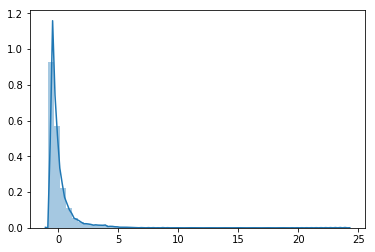

In [14]:
sns.distplot(lm1.resid_pearson)

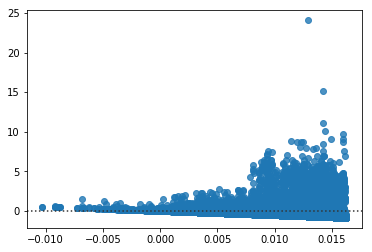

In [15]:
sns.residplot(lm1.fittedvalues, lm1.resid_pearson)

In [16]:
sms.het_breuschpagan(lm1.resid_pearson, lm1.model.exog)

(66.51215967088966,
 3.477418594331947e-16,
 66.67510212237116,
 3.3431494585490715e-16)

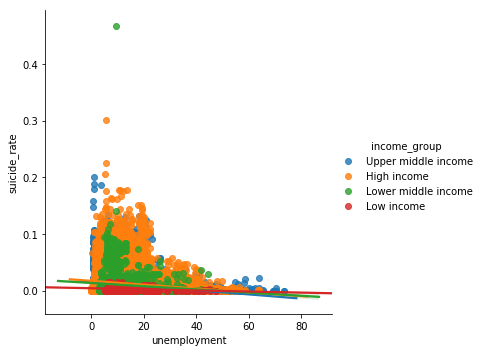

In [17]:
sns.lmplot(x = 'unemployment', y = 'suicide_rate', hue = "income_group", data = suicide, fit_reg = True)

# Model 2: Suicide Rate against everything except country

In [18]:
#Worry about assumptions later
lm2 = smf.ols('suicide_rate~income_group+year+sex+age+unemployment', data=suicide).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     854.8
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:45:23   Log-Likelihood:                 70955.
No. Observations:               26400   AIC:                        -1.419e+05
Df Residuals:                   26388   BIC:                        -1.418e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.4806      0.029     16.624      0.000       0.424       0.537
income_group[T.Low income]             -0.0114      0.001    -13.950      0.000      -0.013      -0.010
income_group[T.Lower middle income]    -0.0033      0.000     -8.731      0.000      -0.004      -0.003
income_group[T.Upper middle income]    -0.0027      0.000    -12.193      0.000      -0.003      -0.002
sex[T.male]                             0.0141      0.000     68.942      0.000       0.014       0.015
age[T.25-34 years]                      0.0033      0.000      8.808      0.000       0.003       0.004
age[T.35-54 years]                      0.0058      0.000     15.433      0.000       0.005       0.007
age[T.5-14 years]                      -0.0081      0.000    -22.991      0.000      -0.009      -0.007
age[T.55-74 years]                      0.0068      0.000     18.030      0.000       0.006       0.007
age[T.75+ years]                        0.0135      0.000     36.156      0.000       0.013       0.014
year                                   -0.0002   1.44e-05    -16.559      0.000      -0.000      -0.000
unemployment                         5.271e-05   1.31e-05      4.019      0.000     2.7e-05    7.84e-05
==============================================================================
Omnibus:                    21017.543   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1292683.332
Skew:                           3.367   Prob(JB):                         0.00
Kurtosis:                      36.613   Cond. No.                     5.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

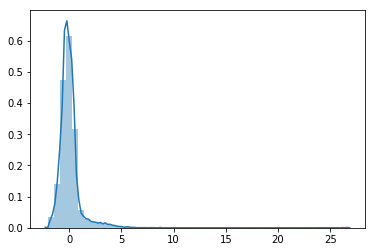

In [19]:
sns.distplot(lm2.resid_pearson)

# Model 3: Fixed Effects

In [20]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [21]:
#year = pd.Categorical(suicide['year'])
suicide = suicide.set_index(['country', 'year'])
#suicide['year'] = year

In [33]:
exog_vars = ['income_group', 'sex', 'age', 'unemployment']
exog = sm.add_constant(suicide[exog_vars])

In [34]:
mod = RandomEffects(suicide['suicide_rate'], exog).fit()
mod.summary

Dep. Variable:,suicide_rate,R-squared:,0.3308
Estimator:,RandomEffects,R-squared (Between):,0.0187
No. Observations:,26400,R-squared (Within):,0.3318
Date:,"Tue, Feb 26 2019",R-squared (Overall):,0.2479
Time:,20:47:48,Log-likelihood,7.603e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1304.7
Entities:,110,P-value,0.0000
Avg Obs:,240.00,Distribution:,"F(10,26389)"
Min Obs:,12.000,,
Max Obs:,312.00,F-statistic (robust):,1305.4


In [39]:
mod2 = PanelOLS(suicide['suicide_rate'], exog, entity_effects=True, time_effects=True).fit()
mod2.summary
#suicide.head()

AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.


# Model 4: Interaction between unemployment and income_group

In [42]:
lm4 = smf.ols('suicide_rate~income_group*unemployment', data=suicide).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     142.9
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          1.13e-207
Time:                        20:55:58   Log-Likelihood:                 67423.
No. Observations:               26400   AIC:                        -1.348e+05
Df Residuals:                   26392   BIC:                        -1.348e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0171      0.000     64.804      0.000       0.017       0.018
income_group[T.Low income]                          -0.0130      0.002     -7.027      0.000      -0.017      -0.009
income_group[T.Lower middle income]                 -0.0038      0.001     -4.651      0.000      -0.005      -0.002
income_group[T.Upper middle income]                 -0.0015      0.000     -3.656      0.000      -0.002      -0.001
unemployment                                        -0.0003   1.88e-05    -17.944      0.000      -0.000      -0.000
income_group[T.Low income]:unemployment              0.0002      0.000      2.299      0.022    3.54e-05       0.000
income_group[T.Lower middle income]:unemployment  5.528e-05   6.01e-05      0.919      0.358   -6.26e-05       0.000
income_group[T.Upper middle income]:unemployment -3.585e-05   2.63e-05     -1.363      0.173   -8.74e-05    1.57e-05
==============================================================================
Omnibus:                    21517.279   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           895307.924
Skew:                           3.652   Prob(JB):                         0.00
Kurtosis:                      30.578   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
Counter(suicide['income_group'])

Counter({'High income': 14892,
         'Low income': 420,
         'Lower middle income': 2232,
         'Upper middle income': 8856})